#### *This version updates:
#### 1. time-varying age-specific proportion in case

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel
from scipy.stats import beta as beta_dist

# infection and hospitalization data
cases = pd.read_csv("/Users/boyapeng/Desktop/Dissertation/Aim1/Data/case_count.csv",header=0)

## Case Handling

In [64]:
# Case count (gaines) 
# Extract Date and Gaines, remove if NA
case_df = (
    cases[["Update Date", "Gaines"]]          # keep only the needed cols
         .loc[1:]
         .assign(
             Gaines=lambda d: pd.to_numeric(d["Gaines"], errors="coerce"),
             Date=lambda d: pd.to_datetime(d["Update Date"])
         )
         .dropna(subset=["Gaines"])           # drop rows where Gaines is NaN
         .set_index("Date")                   # set date as index
         .drop(columns="Update Date")         # drop redundant col
         .sort_index()
)

/var/folders/vy/m4l1bmcs7xd4nmd991yq7qkr0000gn/T/ipykernel_2905/1601191819.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  Date=lambda d: pd.to_datetime(d["Update Date"])


In [65]:
# Prepare the proportion dataframe
prop_path = "/Users/boyapeng/Desktop/Dissertation/Aim1/Data/case_age_prop_ext.csv"
prop_df   = pd.read_csv(prop_path)
prop_df.rename(columns={prop_df.columns[0]: "Date"}, inplace=True)
prop_df[["Prop_0-4", "Prop_5-17", "Prop_18+"]] = prop_df[
    ["Prop_0-4", "Prop_5-17", "Prop_18+"]
].astype(float)
prop_df["Date"] = pd.to_datetime(prop_df["Date"])
prop_df = prop_df.set_index("Date").sort_index()


In [66]:
# Ensure both dataframes cover the same dates
case_aligned = case_df.reindex(prop_df.index)

# Keep only dates where we have a real case count
valid_idx      = case_aligned["Gaines"].notna()   # Boolean mask
case_filtered  = case_aligned.loc[valid_idx]      # drop NaNs
prop_filtered  = prop_df.loc[valid_idx]           # keep matching rows

# Multiply to get age-stratified counts
case_counts = (
    case_filtered["Gaines"].to_numpy().reshape(-1, 1) *
    prop_filtered[["Prop_0-4", "Prop_5-17", "Prop_18+"]].to_numpy()
).round().astype(int).tolist() 

In [67]:
# Time
date = case_df.index.to_series()
ts_cases = ((date - date.iloc[0]).dt.days + date.iloc[0].day).tolist()
n_obs = len(ts_cases)

## Parameters

In [68]:
n_age = 3
N = np.array([2341, 6500, 13682])   ##           set up initial states
VR = np.array([1988, 4536, 11616])
E = np.array([0, 0, 0])
I = np.array([0, 1, 0])

# Initialize y0 vector (length 10*n_age)
y0 = np.zeros(10 * n_age)

# Vaccination rate (daily proportion vaccinated)
v = 0.003

# Vaccine efficacy (leakey)
epsA = 1  
epsL = 0.97

# Exposed to infectious rate
sigma = float(np.random.gamma(shape=10, scale=1/80))

# Infectious to recovered rate
gamma1 = 1/3

# Underreporting rate
rep = 0.9

# Contact matrix (flattened row-major order) ##time-varying
C = np.array([
    1.4101, 2.5282, 4.9100,
    0.9290,11.0091, 6.0771,
    0.4884, 1.6387, 8.8461
])

ts_cases = np.array(ts_cases)

x_r = [v, epsA, epsL, sigma, gamma1, rep] + C.flatten(order='C').tolist()
x_i = [n_age] + N.tolist() + VR.tolist() + E.tolist() + I.tolist()

stan_data = {
    'n_age': n_age,
    'x_r': x_r,
    'x_i': x_i,
    'n_obs_cases': n_obs,
    'ts_cases': ts_cases,
    'cases': case_counts
}



## Model

In [96]:
model = CmdStanModel(stan_file='/Users/boyapeng/Desktop/Dissertation/Aim1/Code/bayesianhmc4_.stan')
fit = model.sample(
    data=stan_data,
    chains=4, # MCMC chains
    parallel_chains=4,
    iter_sampling=300, # samples per chain
    iter_warmup=300,
    adapt_delta=0.95
    #,show_console=True
)

summary = fit.summary()
print(summary)



12:12:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:21:33 - cmdstanpy - INFO - CmdStan done processing.
12:21:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: integrate_ode_rk45: ode parameters and data[1] is inf, but must be finite! (in 'bayesianhmc4_.stan', line 135, column 2 to column 68)
Exception: integrate_ode_rk45: ode parameters and data[2] is inf, but must be finite! (in 'bayesianhmc4_.stan', line 135, column 2 to column 68)
Exception: integrate_ode_rk45: ode parameters and data[1] is inf, but must be finite! (in 'bayesianhmc4_.stan', line 135, column 2 to column 68)
	Exception: integrate_ode_rk45:  Failed to integrate to next output time (29) in less than max_num_steps steps (in 'bayesianhmc4_.stan', line 135, column 2 to column 68)
Consider re-running with show_console=True if the above output is unclear!



                   Mean       MCSE       StdDev          MAD           5%  \
lp__        -457.084000   0.096639     1.884380     1.736870  -460.588000   
beta[1]        4.481070   0.011369     0.251055     0.265652     4.088290   
beta[2]        0.154130   0.000329     0.007192     0.007596     0.142614   
beta[3]        0.175455   0.000243     0.005318     0.005278     0.166882   
con            0.088473   0.000206     0.003946     0.004127     0.082370   
...                 ...        ...          ...          ...          ...   
mse_age[1]    45.797400   0.532525    17.331300    12.449500    27.551500   
mse_age[2]    47.522400   1.070530    31.690000    26.032800    15.558800   
mse_age[3]    67.193900   0.598736    19.076400    16.657500    42.558800   
mse_total     53.504600   0.462043    11.607200    11.475600    38.752400   
ss_total    5457.470000  47.128400  1183.940000  1170.510000  3952.750000   

                    50%          95%  ESS_bulk  ESS_tail     R_hat  
lp__ 

In [97]:
print(summary.iloc[:7, :])

               Mean      MCSE     StdDev        MAD          5%         50%  \
lp__    -457.084000  0.096639   1.884380   1.736870 -460.588000 -456.751000   
beta[1]    4.481070  0.011369   0.251055   0.265652    4.088290    4.475740   
beta[2]    0.154130  0.000329   0.007192   0.007596    0.142614    0.153859   
beta[3]    0.175455  0.000243   0.005318   0.005278    0.166882    0.175339   
con        0.088473  0.000206   0.003946   0.004127    0.082370    0.088245   
t0        24.378600  0.072299   1.475500   1.576080   21.747000   24.489600   
phi1     109.224000  0.810644  20.296100  19.823500   79.019200  108.088000   

                95%  ESS_bulk  ESS_tail    R_hat  
lp__    -454.678000   417.260   599.153  1.00468  
beta[1]    4.915090   492.426   566.542  1.00515  
beta[2]    0.165989   483.817   615.756  1.00279  
beta[3]    0.184513   470.185   716.520  1.00784  
con        0.095345   373.344   590.634  1.00603  
t0        26.601200   419.393   646.428  1.00428  
phi1     1

In [98]:
print(fit.diagnose()) 

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.



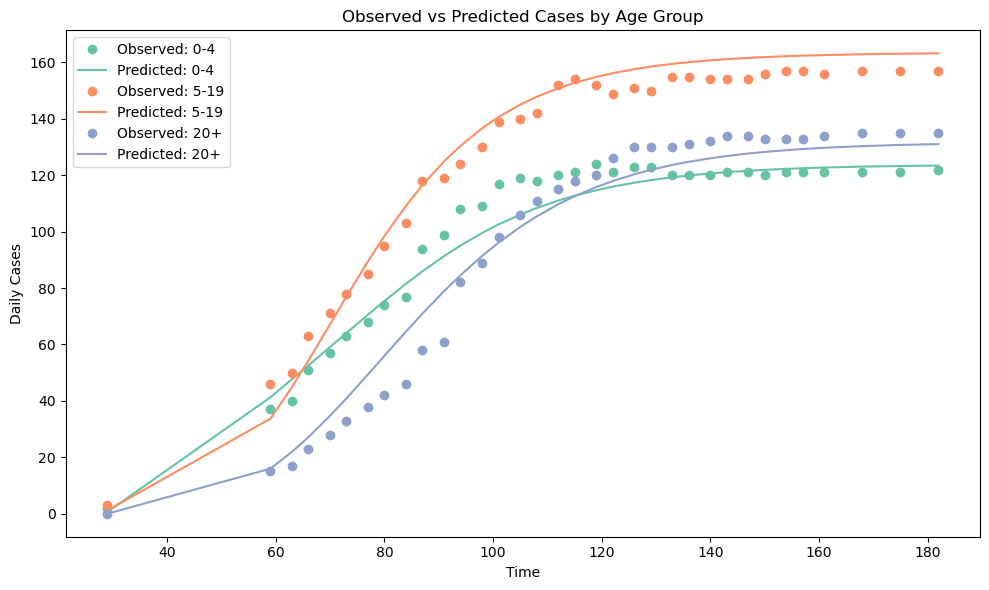

In [99]:
# === Plot posterior predictive ===   .//
import re
import numpy as np
import matplotlib.pyplot as plt

# === Extract and sort pred_cases ===
def extract_indices(name):
    return list(map(int, re.findall(r"\d+", name)))  # returns [i, j]

# Filter and sort pred_cases columns
pred_case_cols = sorted(
    [col for col in fit.column_names if "pred_cases" in col],
    key=lambda x: extract_indices(x)
)

# Get posterior mean and reshape
df_draws = fit.draws_pd()
pred_mean = df_draws[pred_case_cols].mean().values

n_obs = len(set(extract_indices(c)[0] for c in pred_case_cols))
n_age = len(set(extract_indices(c)[1] for c in pred_case_cols))
pred_mean = pred_mean.reshape(n_obs, n_age)

# === Prepare observed cases ===
case_counts = np.array(case_counts)  # Ensure it's a NumPy array if not already

# === Plotting ===
age_labels = ['0-4', '5-19', '20+']
colors = plt.get_cmap('Set2')

plt.figure(figsize=(10, 6))

for i in range(n_age):
    plt.plot(ts_cases, case_counts[:, i], 'o', color=colors(i), label=f'Observed: {age_labels[i]}')
    plt.plot(ts_cases, pred_mean[:, i], '-', color=colors(i), label=f'Predicted: {age_labels[i]}')

plt.xlabel("Time")
plt.ylabel("Daily Cases")
plt.title("Observed vs Predicted Cases by Age Group")
plt.legend()
plt.tight_layout()
plt.show()

In [100]:
#stochasity
beta_cols = [c for c in df_draws.columns if c.startswith("beta[")]
beta_mean = df_draws[beta_cols].mean().values          # β̂ (length = n_age)
beta_std  = df_draws[beta_cols].std().values           # Σβ  (n_age×n_age)\
print(beta_mean)
print(beta_std)

[4.48106583 0.15413031 0.17545458]
[0.2510551  0.00719248 0.00531772]


In [75]:
df_draws[pred_case_cols]

,"pred_cases[1,1]","pred_cases[1,2]","pred_cases[1,3]","pred_cases[2,1]","pred_cases[2,2]","pred_cases[2,3]","pred_cases[3,1]","pred_cases[3,2]","pred_cases[3,3]","pred_cases[4,1]",...,"pred_cases[31,3]","pred_cases[32,1]","pred_cases[32,2]","pred_cases[32,3]","pred_cases[33,1]","pred_cases[33,2]","pred_cases[33,3]","pred_cases[34,1]","pred_cases[34,2]","pred_cases[34,3]"
0,2.0,3.0,0.0,44.0,36.0,17.0,50.0,47.0,23.0,55.0,...,127.0,125.0,161.0,127.0,125.0,162.0,128.0,125.0,162.0,128.0
1,2.0,3.0,0.0,41.0,33.0,15.0,48.0,45.0,21.0,53.0,...,128.0,125.0,163.0,128.0,125.0,163.0,129.0,125.0,163.0,129.0
2,2.0,3.0,0.0,41.0,36.0,16.0,47.0,47.0,22.0,52.0,...,128.0,119.0,163.0,128.0,119.0,164.0,129.0,119.0,164.0,129.0
3,2.0,3.0,0.0,40.0,29.0,15.0,47.0,40.0,21.0,52.0,...,133.0,127.0,157.0,134.0,127.0,157.0,134.0,127.0,157.0,135.0
4,2.0,3.0,0.0,40.0,31.0,15.0,46.0,42.0,21.0,52.0,...,133.0,125.0,158.0,133.0,125.0,158.0,134.0,125.0,158.0,134.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,2.0,3.0,0.0,39.0,32.0,15.0,46.0,44.0,21.0,50.0,...,130.0,121.0,162.0,131.0,122.0,162.0,131.0,122.0,162.0,131.0
3996,2.0,3.0,0.0,41.0,35.0,17.0,48.0,47.0,23.0,53.0,...,129.0,122.0,159.0,130.0,122.0,160.0,130.0,122.0,160.0,130.0
3997,2.0,3.0,0.0,40.0,31.0,15.0,47.0,42.0,21.0,52.0,...,132.0,126.0,160.0,133.0,126.0,160.0,133.0,126.0,161.0,133.0
3998,2.0,3.0,0.0,40.0,30.0,15.0,47.0,41.0,21.0,52.0,...,131.0,126.0,159.0,131.0,126.0,159.0,132.0,126.0,159.0,132.0


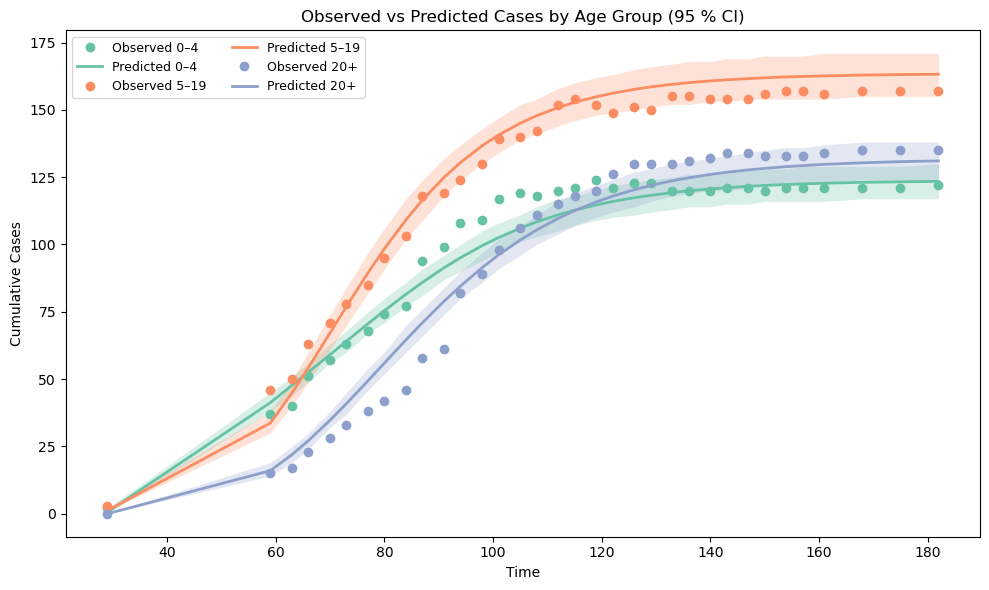

In [101]:
# -----------------------------------------------
# 1 ── reshape into (n_draws, n_obs, n_age)
# -----------------------------------------------
n_obs = max(idx[0] for idx in map(extract_indices, pred_case_cols))
n_age = max(idx[1] for idx in map(extract_indices, pred_case_cols))

draws = df_draws[pred_case_cols]
arr = draws.to_numpy().reshape(len(draws), n_obs, n_age)   # posterior draws → 3-D

# statistics along draw axis = 0
pred_mean = arr.mean(axis=0)            # (n_obs, n_age)
pred_lo   = np.percentile(arr,  2.5, axis=0)
pred_hi   = np.percentile(arr, 97.5, axis=0)

# -----------------------------------------------
# 2 ── plotting with 95 % ribbon
# -----------------------------------------------
age_labels = ['0–4', '5–19', '20+']
colors     = plt.get_cmap('Set2')

plt.figure(figsize=(10, 6))

for i in range(n_age):
    # observed points
    plt.plot(ts_cases, case_counts[:, i],
             'o', color=colors(i), label=f'Observed {age_labels[i]}')

    # 95 % CI ribbon
    plt.fill_between(ts_cases,
                     pred_lo[:, i], pred_hi[:, i],
                     color=colors(i), alpha=0.25, linewidth=0)

    # posterior mean (or median) curve
    plt.plot(ts_cases, pred_mean[:, i],
             '-', color=colors(i), lw=2, label=f'Predicted {age_labels[i]}')

plt.xlabel("Time")
plt.ylabel("Cumulative Cases")        # or Daily Cases if that’s your unit
plt.title("Observed vs Predicted Cases by Age Group (95 % CI)")
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()


In [102]:
# ────────────────────────────────────────────────────────────────
#   95 % predictive interval coverage over data points
#     (proportion of y_obs lying inside 2.5 %–97.5 % band)
# ────────────────────────────────────────────────────────────────
y_obs = case_counts
inside = (y_obs >= pred_lo) & (y_obs <= pred_hi)           # boolean (N, 3)

# Proportion covered, by age group and overall
coverage_age   = inside.mean(axis=0)             # length-3 vector
coverage_total = inside.mean()                   # single scalar

print("Age-group coverage :", coverage_age)
print("Overall  coverage :", coverage_total)

Age-group coverage : [0.64705882 0.88235294 0.61764706]
Overall  coverage : 0.7156862745098039


## Diagnosis

In [103]:
# -------------------------------------------
# Leave-One-Out cross-validation (predictive performance)
# -------------------------------------------
import arviz as az
idata = az.from_cmdstanpy(fit, log_likelihood="log_lik")
az.waic(idata) #LOOIC ≈ 737.7
az.loo(idata)

/opt/anaconda3/lib/python3.12/site-packages/arviz/stats/stats.py:1655: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 1200 posterior samples and 102 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -378.67     5.22
p_loo        3.00        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.68]   (good)      102  100.0%
   (0.68, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

Posterior mean MSE by age group: [45.79740267 47.52240117 67.1939015 ]
Posterior mean overall MSE: 53.504566833333335
95 % CI   : [52.8472, 54.1620]


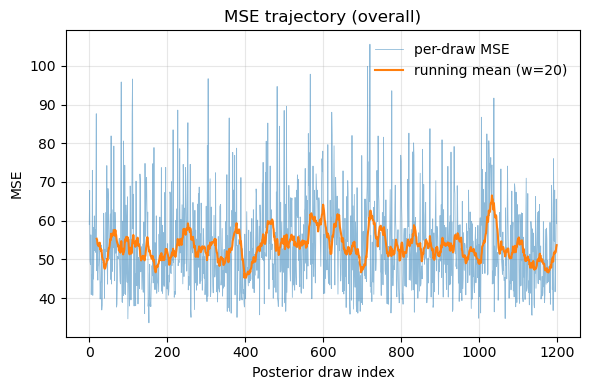

In [106]:
# ---------------------------------------------------------------
# Diagnostics: MSE path  + coverage table
# ---------------------------------------------------------------
from scipy.stats import t

mse_age_draws  = fit.stan_variable("mse_age")   # shape (draws, n_age)
mse_total_draws = fit.stan_variable("mse_total")
mse_mean = mse_total_draws.mean()

# ── 95 % CI for the mean, using finite-sample t interval ───────
n       = len(mse_total_draws)
s       = mse_total_draws.std(ddof=1)
t_star  = t.ppf(1 - 0.05/2, df=n - 1)
halfwid = t_star * s / np.sqrt(n)
ci_low, ci_high = mse_mean - halfwid, mse_mean + halfwid

print("Posterior mean MSE by age group:",
      mse_age_draws.mean(axis=0))
print("Posterior mean overall MSE:",
      mse_total_draws.mean())
print(f"95 % CI   : [{ci_low:.4f}, {ci_high:.4f}]")

# ---------------------------------------------------------------
#  MSE trajectory plot (overall + age-specific, optional)
# ---------------------------------------------------------------
# ── overall MSE (one scalar per posterior draw) ────────────────
mse_total_draws = fit.stan_variable("mse_total")   # shape (draws,)

# OPTIONAL: per-age-group MSE, if you also stored `mse_age`
# mse_age_draws = fit.stan_variable("mse_age")      # shape (draws, n_age)

# ── running mean for a smoother curve (window = 20 draws) ─────
def running_mean(x, w=20):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[w:] - cumsum[:-w]) / w

fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(mse_total_draws,
        lw=0.6, label="per-draw MSE", alpha=0.5)
ax.plot(np.arange(19, len(mse_total_draws)),
        running_mean(mse_total_draws, w=20),
        lw=1.5, label="running mean (w=20)")

ax.set_xlabel("Posterior draw index")
ax.set_ylabel("MSE")
ax.set_title("MSE trajectory (overall)")
ax.legend(frameon=False)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [107]:
# -------------------------------------------
#   Extra reporting 
# -------------------------------------------
ess_bulk = fit.summary()['ESS_bulk'].min()
rhat_max = fit.summary()['R_hat'].max()
print(f"Bulk-ESS (min)               : {ess_bulk:10.1f}")
print(f"R̂   (max)                   : {rhat_max:10.3f}")

Bulk-ESS (min)               :      342.7
R̂   (max)                   :      1.011


In [ ]:
# -------------------------------------------
# Running Time
# -------------------------------------------
import time, numpy as np, arviz as az, pandas as pd
from cmdstanpy import CmdStanModel, cmdstan_path
from scipy.stats import t

def ci_mean(samples, alpha=0.05):
    """Mean ± CI for arbitrary vector of samples."""
    m      = np.mean(samples)
    s      = np.std(samples, ddof=1)
    n      = len(samples)
    t_star = t.ppf(1 - alpha/2, df=n-1)
    half   = t_star * s / np.sqrt(n)
    return m, (m - half, m + half)

# -------------------------------------------
# 1.  Compile & fit
# -------------------------------------------
model = CmdStanModel(stan_file='/Users/boyapeng/Desktop/Dissertation/Aim1/Code/bayesianhmc4_.stan')

# --- repeated runs to get timing distribution ----
n_runs = 20                  
fit_times = []
fits      = []

for r in range(n_runs):
    t0 = time.perf_counter()

    fit = model.sample(
        data            = stan_data,          # << provide
        chains          = 4,
        parallel_chains = 4,
        iter_warmup     = 300,
        iter_sampling   = 400,
        adapt_delta     = 0.95,
        show_progress   = False,              # quiet tqdm
    )

    fit_times.append(time.perf_counter() - t0)
    fits.append(fit)

# --- timing summary ---------------------------------------------
mean_t, (lo_t, hi_t) = ci_mean(fit_times, alpha=0.05)
print(f"Wall-clock time  (mean ±95% CI) : {mean_t:6.2f} s  "
      f"[{lo_t:6.2f}, {hi_t:6.2f}]")

13:39:18 - cmdstanpy - INFO - CmdStan start processing
13:39:18 - cmdstanpy - INFO - Chain [1] start processing
13:39:18 - cmdstanpy - INFO - Chain [2] start processing
13:39:18 - cmdstanpy - INFO - Chain [3] start processing
13:39:18 - cmdstanpy - INFO - Chain [4] start processing
13:44:18 - cmdstanpy - INFO - Chain [4] done processing
13:44:51 - cmdstanpy - INFO - Chain [2] done processing
13:45:02 - cmdstanpy - INFO - Chain [1] done processing
13:47:21 - cmdstanpy - INFO - Chain [3] done processing
13:47:21 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: integrate_ode_rk45: ode parameters and data[2] is inf, but must be finite! (in 'bayesianhmc4_.stan', line 135, column 2 to column 68)
	Exception: integrate_ode_rk45:  Failed to integrate to next output time (29) in less than max_num_steps steps (in 'bayesianhmc4_.stan', line 135, column 2 to column 68)
Consider re-running with show_console=True if the above output is unclear!
13:47:21 - cmdstanpy - INFO - CmdStan

## Parameter Prior v.s. Posterior

In [8]:
import scipy.stats as stats

In [21]:
# Number of points to plot for prior curves
xpts = 500

priors = {
    "beta": {
        "dist": stats.lognorm(s=0.3, scale=np.exp(2)),
        "label": "lognormal(log(2), 0.3)",
    },
    "con": {
        "dist": stats.beta(a=2, b=2), #(0.094, 0.906)
        "label": "beta(2,2)", 
    },
    "t0": {
        "dist": stats.norm(loc=19, scale=3),
        "label": "normal(19, 3)",
    },
    "phi1": {
        "dist": stats.cauchy(loc=0, scale=5),
        "label": "cauchy(0, 5)",
    },
    #"phi2": {
    #    "dist": stats.gamma(a=2, scale=1/0.1),  # scale = 1/rate
    #    "label": "gamma(2, 0.1)"
   #}
}


In [22]:
def plot_prior_posterior(param_name, posterior_samples, prior_dist, prior_label):
    fig, ax = plt.subplots(figsize=(6, 4))

    # Plot posterior histogram (raw counts, not density)
    counts, bins, _ = ax.hist(
        posterior_samples,
        bins=50,
        density=False,
        alpha=0.6,
        color='orange',
        edgecolor='black',
        label="Posterior"
    )

    # Define x-range for prior using the histogram range
    x = np.linspace(bins[0], bins[-1], 500)
    y_prior = prior_dist.pdf(x)

    # Scale prior to match histogram height
    y_prior_scaled = y_prior * max(counts) / max(y_prior) if np.max(y_prior) > 0 else y_prior

    # Plot scaled prior
    ax.plot(x, y_prior_scaled, 'r-', lw=2, label=f"Prior: {prior_label}")

    ax.set_title(f"{param_name}: Prior vs Posterior")
    ax.set_xlabel(param_name)
    ax.set_ylabel("Frequency")
    ax.legend()
    plt.tight_layout()
    plt.show()


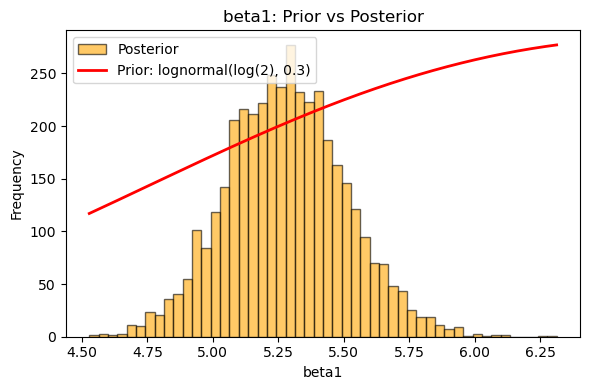

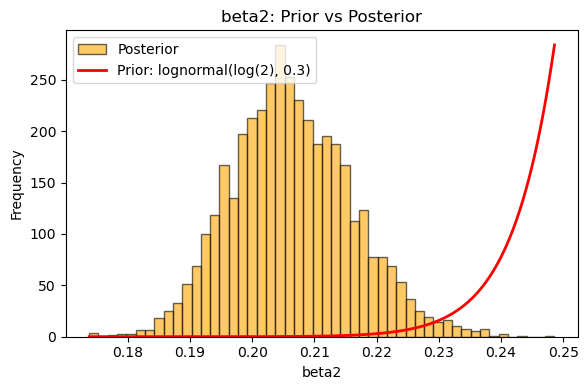

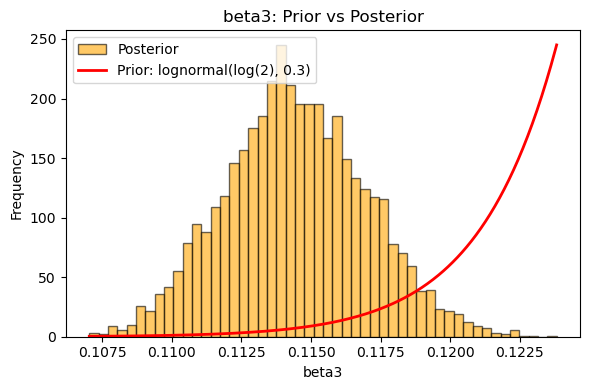

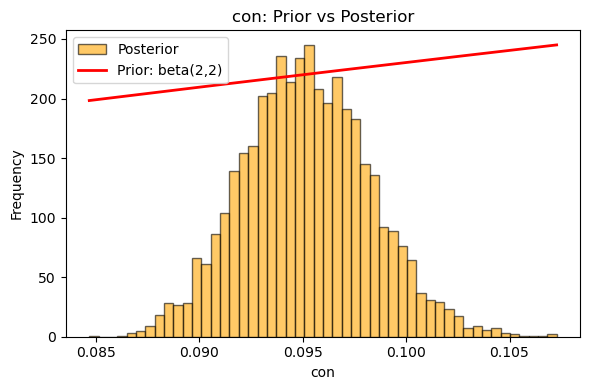

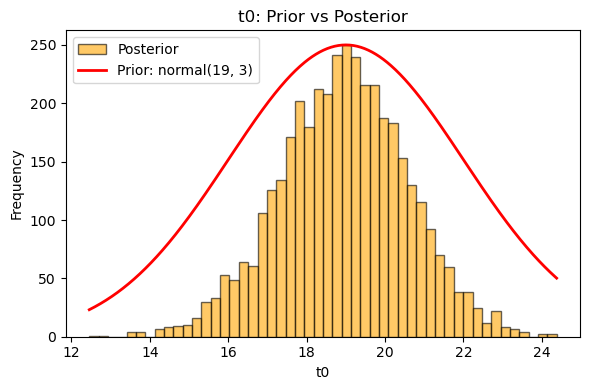

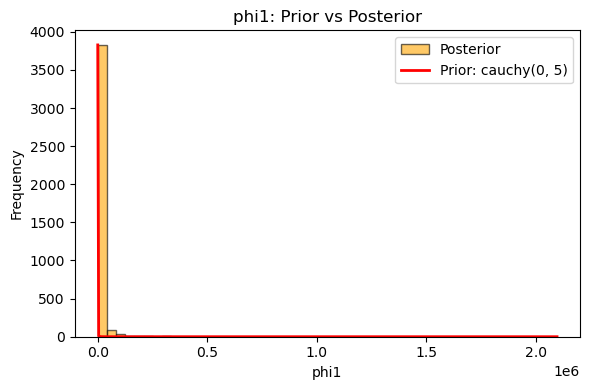

In [23]:
for name, spec in priors.items():
    # --- vector case ----------------------------------------------------
    if name == "beta":                       # <- treat β specially
        beta_cols = [c for c in draws.columns if c.startswith("beta[")]
        for col in beta_cols:
            idx = col.split("[")[1].split("]")[0]          # "1", "2", "3"
            posterior_samples = draws[col].dropna()
            plot_prior_posterior(f"beta{idx}",
                                 posterior_samples,
                                 spec["dist"],
                                 spec["label"])
    # --- scalar case ----------------------------------------------------
    else:
        posterior_samples = draws[name].dropna()
        plot_prior_posterior(name,
                             posterior_samples,
                             spec["dist"],
                             spec["label"])

In [12]:
beta_samples = fit.stan_variable("beta")
print(beta_samples)

[[5.0334   0.188222 0.111286]
 [5.08256  0.197383 0.113985]
 [5.3004   0.20858  0.114059]
 ...
 [5.42979  0.220526 0.114309]
 [5.63537  0.215915 0.110804]
 [4.97489  0.195693 0.113927]]


In [20]:
con_samples = fit.stan_variable("con")
print(con_samples)

[0.101951  0.0965846 0.0943921 ... 0.0915741 0.0931671 0.0988092]


In [44]:
phi2_samples = fit.stan_variable("phi2")
print(phi2_samples)
print(np.percentile(phi2_samples, [2.5, 50, 97.5]))
print("Max:", np.max(phi2_samples))

[ 5.24693  4.06448 10.4086  ...  1.81046  1.3053  11.1649 ]
[1.32628325e-01 5.00000500e+00 1.56337625e+02]
Max: 87102.5


array([[<Axes: title={'center': 'phi2'}>,
        <Axes: title={'center': 'phi2'}>]], dtype=object)

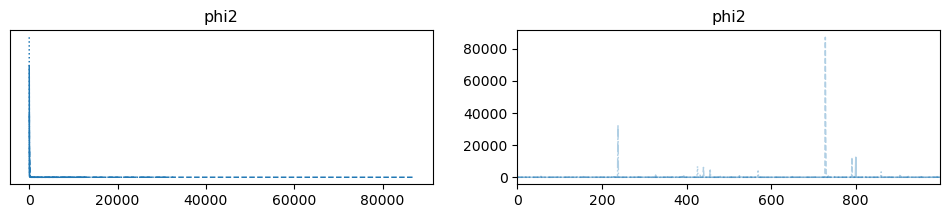

In [48]:
import arviz as az
az.plot_trace(fit, var_names=["phi2"])

In [50]:
fit.summary().loc["phi2"]

Mean          70.236200
MCSE          30.159900
StdDev      1556.770000
MAD            5.620430
5%             0.288699
50%            5.000000
95%           71.587500
ESS_bulk    4393.210000
ESS_tail    1839.910000
R_hat          1.001780
Name: phi2, dtype: float64